In [1]:
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

import pandas as pd
import numpy as np

from scipy.stats import boxcox

data = pd.read_csv('./data/18-20.csv')
data['测定日期'] = data['测定日期'].astype('datetime64[D]')
data['出生日期'] = data['出生日期'].astype('datetime64[D]')
data['测定日期'] = pd.to_datetime(data['测定日期'])
data.head()

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,序号,品系,性别,测定日期,出生日期,weight,L,体高,FG,BG,MG
0,4386,美系杜洛克,母,2018-01-03,2017-07-18,108.5,1.18,61,1.05,1.15,1.03
1,4387,美系杜洛克,母,2018-01-03,2017-07-21,105.0,1.18,61,1.06,1.18,1.05
2,4388,美系杜洛克,母,2018-01-03,2017-07-21,106.5,1.19,62,1.07,1.15,1.05
3,4389,美系杜洛克,母,2018-01-03,2017-07-20,105.0,1.18,62,1.06,1.18,1.04
4,4390,美系杜洛克,母,2018-01-03,2017-07-11,108.8,1.20,63,1.07,1.18,1.04


In [2]:
data.shape

(4149, 11)

In [3]:
if(data.shape[1]==11):
    data = data.drop(['序号'],axis=1)
    
class_map = {'美系杜洛克':0,'台系杜洛克':1}
data['品系'] = data['品系'].map(class_map)
sex_map = {'母':0, '公':1}
data['性别'] = data['性别'].map(sex_map)
w = data['weight']


data

,品系,性别,测定日期,出生日期,weight,L,体高,FG,BG,MG
0,0,0,2018-01-03,2017-07-18,108.5,1.18,61,1.05,1.15,1.03
1,0,0,2018-01-03,2017-07-21,105.0,1.18,61,1.06,1.18,1.05
2,0,0,2018-01-03,2017-07-21,106.5,1.19,62,1.07,1.15,1.05
3,0,0,2018-01-03,2017-07-20,105.0,1.18,62,1.06,1.18,1.04
4,0,0,2018-01-03,2017-07-11,108.8,1.20,63,1.07,1.18,1.04
...,...,...,...,...,...,...,...,...,...,...
4144,1,0,2020-02-21,2019-08-25,106.3,1.18,63,1.07,1.18,1.06
4145,1,0,2020-02-21,2019-08-25,110.4,1.20,64,1.06,1.14,1.03
4146,1,0,2020-02-21,2019-08-25,111.7,1.17,63,1.09,1.18,1.07
4147,1,0,2020-02-21,2019-08-24,107.6,1.20,64,1.06,1.14,1.04


In [32]:
data['weight'].value_counts().head(30)

100.0    172
105.0     87
100.5     84
100.3     84
105.3     73
100.2     71
110.2     66
101.2     62
105.2     60
102.3     57
100.7     57
105.7     56
101.3     56
110.5     55
105.6     52
101.5     51
110.3     48
100.1     46
101.0     46
106.3     45
101.7     42
101.4     42
100.4     41
112.3     40
111.5     39
110.7     39
110.0     38
113.5     38
103.5     35
106.5     33
Name: weight, dtype: int64

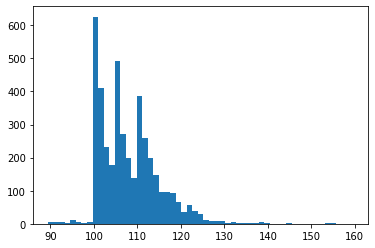

In [29]:
import matplotlib.pyplot as plt

www = data['weight'].values
pc = np.linspace(89.5,159.5,56)
plt.hist(www,pc)
# plt.xticks(range(90,160,)
plt.show()

In [4]:
df = (data['测定日期']-data['出生日期'])
df.name = '年龄'
df = df.dt.days

data = data.join(df)
data.info


<bound method DataFrame.info of       品系  性别       测定日期       出生日期  weight     L  体高    FG    BG    MG   年龄
0      0   0 2018-01-03 2017-07-18   108.5  1.18  61  1.05  1.15  1.03  169
1      0   0 2018-01-03 2017-07-21   105.0  1.18  61  1.06  1.18  1.05  166
2      0   0 2018-01-03 2017-07-21   106.5  1.19  62  1.07  1.15  1.05  166
3      0   0 2018-01-03 2017-07-20   105.0  1.18  62  1.06  1.18  1.04  167
4      0   0 2018-01-03 2017-07-11   108.8  1.20  63  1.07  1.18  1.04  176
...   ..  ..        ...        ...     ...   ...  ..   ...   ...   ...  ...
4144   1   0 2020-02-21 2019-08-25   106.3  1.18  63  1.07  1.18  1.06  180
4145   1   0 2020-02-21 2019-08-25   110.4  1.20  64  1.06  1.14  1.03  180
4146   1   0 2020-02-21 2019-08-25   111.7  1.17  63  1.09  1.18  1.07  180
4147   1   0 2020-02-21 2019-08-24   107.6  1.20  64  1.06  1.14  1.04  181
4148   1   0 2020-02-21 2019-08-24   103.7  1.19  64  1.07  1.15  1.03  181

[4149 rows x 11 columns]>

In [52]:
x = data.drop('测定日期',axis=1)
x = x.drop('出生日期',axis =1)

x = x.drop('weight',axis=1)

x = x.values
w = w.values
ww = []
xx = []

for i in range(len(w)):
    if abs(w[i]-100.1) > 0.1 and abs(w[i]-105.1) > 0.1 and abs(w[i]-110.1) > 0.1:
        ww.append(w[i])
        xx.append(x[i])
        
x = pd.DataFrame(x)
w = pd.DataFrame(w)
ww = np.array(ww)
xx = np.array(xx)
len(xx)

3764

In [53]:
# y_train, y_test, x_train, x_test = train_test_split(y, data, test_size=0.1)
y_train, y_test, x_train, x_test = train_test_split(ww, xx, test_size=0.1)

ss_x = StandardScaler()
ss_y = StandardScaler()

x_train = ss_x.fit_transform(x_train)
x_test = ss_x.transform(x_test)
y_train = ss_y.fit_transform(y_train.reshape(-1,1))
y_test = ss_y.transform(y_test.reshape(-1,1))

In [87]:
from sklearn.model_selection import RandomizedSearchCV

rs = 15

rf = RandomForestRegressor(random_state = rs)

# Number of trees in random forest
n_estimators = [100,150, 200, 250, 300, 350, 450, 550]

# Minimum number of samples required to split a node
min_samples_split = [2,4,6,8,10,12,14]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]

# Create the random grid
random_grid = {'n_estimators': range(100,600,100),
               'min_samples_split': range(2,20,2),
               'min_samples_leaf': range(1,20,3)}

rf_randomsearch = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 5,
                               cv = 5,
                               verbose = 2,
                               random_state = rs,
                               n_jobs = 3)

rf_randomsearch.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:   20.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=1

In [88]:
rf_randomsearch.best_params_

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4}

In [98]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer


# model = XGBRegressor()
model = RandomForestRegressor(n_estimators=300,min_samples_leaf=4,min_samples_split=2)

# 网格搜索

# parameters = {'kernel':['rbf','poly'],'gamma':[i/5 for i in range(1,3)]}
# scorer = make_scorer(metrics.mean_squared_error)
# grid_obj = GridSearchCV(model, parameters,scoring=scorer, cv = 3)
# grid_fit = grid_obj.fit(x_train,y_train)
# best_md = grid_fit.best_estimator_

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(metrics.r2_score(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_pred)))
print(metrics.mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_pred)))
print(metrics.mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


0.7443278729024119
10.863924058313941
2.3120309708288835


In [10]:
RandomForestRegressor?